# Viral Data Analysis

Date: 2020.10.26

Author: © 2020 Eimantas Morkūnas 

This notebook is part of an individual project for [KTU IF](https://fi.ktu.edu/)  [P176M010 Advanced Machine Learning](https://admissions.ktu.edu/programme/m-software-engineering/#P176M010) class led by [M. Lukoševičius](http://mantas.info/).

Here we analyze open COVID-19 data from https://ourworldindata.org/ to answer the following questions:

1. [Which European countries did best and worst to flatten the active cases curve?](#Q1)
1. [Is COVID-19 case fatality rate lower in European countries that have a flatter active cases curve?](#Q2)
1. [Does using active cases data improve prediction accuracy of daily deaths in Belgium compared to using only historical daily deaths data when using Linear Regression?](#Q3)

We additionally use data from:
* [COVID-19 Data Repository by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University] (https://github.com/CSSEGISandData/COVID-19)

This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International license</a>. <a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons license" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/80x15.png" /></a> 

## Preparations

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso

### Get and load data sets

Download the data sets to cache locally. Fetches are commented out as to not DoS the servers with every re-run (adopted from https://stackoverflow.com/a/35997720).

In [2]:
import requests

def fetch_file(url):
    request = requests.get(url)
    file_name = url.split('/')[-1]
    open(file_name, 'wb').write(request.content)

# fetch_file('https://covid.ourworldindata.org/data/owid-covid-data.csv')
# fetch_file('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

Load both data set files using Pandas.

In [3]:
owid_df = pd.read_csv('owid-covid-data.csv', parse_dates=[3])
recovered_df = pd.read_csv('time_series_covid19_recovered_global.csv')

### Clean up and transform data sets

OWID data set does not require a lot of clean up - just need to remove rows with invalid `iso_code` and `continent` columns.

In [4]:
owid_df = owid_df.dropna(subset=['iso_code', 'continent'])

CSSE recoveries data set will need to be transformed before it can be used alongside OWID data set because it has a different structure:

In [5]:
recovered_df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,10/16/20,10/17/20,10/18/20,10/19/20,10/20/20,10/21/20,10/22/20,10/23/20,10/24/20,10/25/20
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,33516,33561,33614,33760,33790,33824,33831,34010,34023,34129
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,9957,10001,10071,10167,10225,10341,10395,10466,10548,10654
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,37856,37971,38088,38215,38346,38482,38618,38788,38932,39095
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,2057,2057,2057,2273,2273,2470,2470,2729,2729,2729
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,3012,3022,3030,3031,3037,3040,3305,3384,3461,3508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,...,39921,40162,40498,40861,41455,41935,42544,42850,43232,43592
250,NaN,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,...,8,8,8,8,8,8,8,8,8,8
251,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,1335,1336,1338,1338,1338,1344,1344,1354,1360,1360
252,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,...,14899,14927,15005,15031,15038,15168,15168,15179,15179,15179


For some larger countries (e.g. France) recoveries data is provided by province or state:

In [6]:
recovered_df[recovered_df['Country/Region'] == 'France']

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,10/16/20,10/17/20,10/18/20,10/19/20,10/20/20,10/21/20,10/22/20,10/23/20,10/24/20,10/25/20
103,French Guiana,France,3.933900,-53.125800,0,0,0,0,0,0,...,9955,9982,9982,9995,9995,9995,9995,9995,9995,9995
104,French Polynesia,France,-17.679700,149.406800,0,0,0,0,0,0,...,2844,2844,2844,3202,3202,3536,3536,3623,3623,3685
105,Guadeloupe,France,16.265000,-61.551000,0,0,0,0,0,0,...,2199,2199,2199,2199,2199,2199,2199,2199,2199,2199
106,Martinique,France,14.641500,-61.024200,0,0,0,0,0,0,...,98,98,98,98,98,98,98,98,98,98
107,Mayotte,France,-12.827500,45.166244,0,0,0,0,0,0,...,2964,2964,2964,2964,2964,2964,2964,2964,2964,2964
108,New Caledonia,France,-20.904305,165.618042,0,0,0,0,0,0,...,27,27,27,27,27,27,27,27,27,27
109,Reunion,France,-21.115100,55.536400,0,0,0,0,0,0,...,4445,4445,4445,4445,4445,4445,4445,4630,4630,4630
110,Saint Barthelemy,France,17.900000,-62.833300,0,0,0,0,0,0,...,55,55,55,55,55,66,66,66,66,66
111,Saint Pierre and Miquelon,France,46.885200,-56.315900,0,0,0,0,0,0,...,12,12,12,12,12,12,12,12,12,12
112,St Martin,France,18.070800,-63.050100,0,0,0,0,0,0,...,380,380,380,380,380,422,422,422,422,422


Only country-wide data is relevant to us. Let us remove the unnecessary `Province/State` and `Lat`/`Long` columns and group rows by country, summing up columns of duplicate rows. This will result in a single row per country with regional data summed up. This will also make `Country/Region` column the index of the data frame.

In [7]:
recovered_df = recovered_df.drop(['Province/State', 'Lat', 'Long'], axis='columns')
recovered_df = recovered_df.groupby('Country/Region').sum()
recovered_df.loc['France'].tail(1)

10/25/20    114534
Name: France, dtype: int64

The data set has some irregularities and missing data. We address those by changing negative values for recovered cases to zero and dropping countries (rows) that have no data. 

In [8]:
recovered_df = recovered_df.applymap(lambda recoveries : recoveries if recoveries >= 0 else 0)

rows_before = len(recovered_df.index)
recovered_df = recovered_df.loc[(recovered_df != 0).any(axis='columns')]
rows_after = len(recovered_df.index)
f'Empty rows removed: {rows_before - rows_after}'

'Empty rows removed: 2'

Country names between OWID and recoveries data sets might not match exactly. To ease joining the two data sets we convert country names to alpha-3 country codes that will match `iso_code` column in OWID data frame. We also rename `Country/Region` index to `iso_code` to match OWID frame.

Country names conversion is done mostly by [pycountry](https://pypi.org/project/pycountry/) module with some manual help for more complicated cases.

In [9]:
import pycountry

def country_name_to_iso_code(countryName):
    if countryName == 'Kosovo':
        return 'OWID_KOS'

    country = pycountry.countries.get(name=countryName)
    if country is not None:
        return country.alpha_3

    try:
        return pycountry.countries.search_fuzzy(countryName)[0].alpha_3
    except LookupError:
        if countryName == 'Burma':
            return 'MMR'
        if countryName == 'Congo (Brazzaville)':
            return 'COG'
        if countryName == 'Congo (Kinshasa)':
            return 'COD'
        if countryName == 'Korea, South':
            return 'KOR'
        if countryName == 'Laos':
            return 'LAO'
        if countryName == 'Taiwan*':
            return 'TWN'
        if countryName == 'West Bank and Gaza':
            return 'PSE'

        return None

recovered_df = recovered_df.set_index(recovered_df.index.map(lambda countryName : country_name_to_iso_code(countryName)))
recovered_df = recovered_df.rename_axis('iso_code', axis='rows')

Column labels for recoveries data set is dates but are currently stored as strings. Parse them to datetime objects.

In [10]:
recovered_df.columns = pd.to_datetime(recovered_df.columns)

At the moment recoveries data frame has a row per country and a column per day. OWID frame has a row per day per country. We need to change the shape of recoveries data frame to match OWID format.

In [11]:
recovered_df = recovered_df.melt(var_name='date', value_name='total_recoveries', ignore_index=False).reset_index()
recovered_df

,iso_code,date,total_recoveries
0,AFG,2020-01-22,0
1,ALB,2020-01-22,0
2,DZA,2020-01-22,0
3,AND,2020-01-22,0
4,AGO,2020-01-22,0
...,...,...,...
51981,PSE,2020-10-25,43592
51982,ESH,2020-10-25,8
51983,YEM,2020-10-25,1360
51984,ZMB,2020-10-25,15179


### Merge data sets

Finally, we can combine the two data sets into a single data frame. We do this by setting `iso_code` and `date` as multi-index for both data frames and concatenating them. We use inner join to ensure that all rows will have data available from both data sets.

In [12]:
df = pd.concat([owid_df.set_index(['iso_code', 'date']), recovered_df.set_index(['iso_code', 'date'])], join='inner', axis='columns').reset_index()

We then calculate additional columns that will be needed later.

In [13]:
df['total_recoveries_per_million'] = df['total_recoveries'] / df['population'] * 1000000
df['active_cases'] = df['total_cases'] - df['total_recoveries'] - df['total_deaths']
df['active_cases_per_million'] = df['active_cases'] / df['population'] * 1000000

df[['iso_code', 'date', 'total_recoveries', 'total_recoveries_per_million', 'active_cases', 'active_cases_per_million']]

,iso_code,date,total_recoveries,total_recoveries_per_million,active_cases,active_cases_per_million
0,AFG,2020-01-22,0,0.000000,NaN,NaN
1,AFG,2020-01-23,0,0.000000,NaN,NaN
2,AFG,2020-01-24,0,0.000000,NaN,NaN
3,AFG,2020-01-25,0,0.000000,NaN,NaN
4,AFG,2020-01-26,0,0.000000,NaN,NaN
...,...,...,...,...,...,...
45032,ZWE,2020-10-21,7725,519.749576,229.0,15.407463
45033,ZWE,2020-10-22,7742,520.893361,237.0,15.945715
45034,ZWE,2020-10-23,7771,522.844525,235.0,15.811152
45035,ZWE,2020-10-24,7785,523.786465,236.0,15.878434


<a id='Q1'></a>
## 1. Which European countries did best and worst to flatten the active cases curve?

At the start of the pandemic there was a lot of talk about "flattening the curve". The catchphrase was referring to active cases curve. The idea was to spread out the inevitable COVID-19 cases over time, avoiding spikes in active cases with which healthcare systems would not been able to cope with. The strategy was not aiming to completely stop the spread of the virus but rather to limit the spread and maintain a constant number of active cases. 

To figure out which European countries did best to implement this strategy we first get a list of countries that we will be looking into. Beside taking countries in Europe we also drop countries that in the last day had less than 200 total recoveries. Aim here is to weed out countries that were not affected by the coronavirus yet or do not have recent recoveries data (latter notably applies to United Kingdom and Serbia).

In [14]:
eu_df = df[df.continent == 'Europe']

eu_last_day_stats = eu_df.groupby('iso_code').last()
valid_countries = eu_last_day_stats[eu_last_day_stats.total_recoveries_per_million > 200].index.values
valid_countries

array(['ALB', 'AND', 'AUT', 'BEL', 'BGR', 'BIH', 'BLR', 'CHE', 'CYP',
       'CZE', 'DEU', 'DNK', 'ESP', 'EST', 'FIN', 'FRA', 'HRV', 'HUN',
       'IRL', 'ISL', 'ITA', 'LIE', 'LTU', 'LUX', 'LVA', 'MCO', 'MDA',
       'MKD', 'MLT', 'MNE', 'NLD', 'NOR', 'OWID_KOS', 'POL', 'PRT', 'ROU',
       'RUS', 'SMR', 'SVK', 'SVN', 'UKR', 'VAT'], dtype=object)

We expect flat curves to not change much (or at all) over time. To evaluate how flat the active cases curve for a country is we will calculate the % change of active cases for every day compared to the day prior and take the average of absolute % change values. Flatter curves should have a value closer to 0%.

When the virus starts to spread the recoveries data is delayed as it takes time to recover. To avoid rapid increases without recoveries at the start of the pandemic, we filter out the days where there were less than 100 total recoveries per million people in the country.

To account for inconsistent reporting of new cases or/and recoveries we smooth out the active cases % change over 14 days.

In [15]:
active_cases_delta_averages = {}
for country in valid_countries:
    country_stats = eu_df[eu_df.iso_code == country]

    threshold_index = country_stats[country_stats.total_recoveries_per_million > 125].index[0]
    relevant_stats = country_stats.loc[threshold_index:]

    relevant_stats['active_cases_delta'] = relevant_stats.active_cases.diff()
    relevant_stats['active_cases_perc_delta'] = relevant_stats.active_cases_delta * 100 / relevant_stats.active_cases.shift(1)
    relevant_stats['active_cases_perc_delta_smoothed'] = relevant_stats['active_cases_perc_delta'].rolling(14).mean()

    active_cases_delta_averages[country] = relevant_stats.active_cases_perc_delta_smoothed.abs().mean()

active_cases_perc_delta_average_by_country = pd.Series(active_cases_delta_averages).sort_values().dropna()
active_cases_perc_delta_average_by_country

RUS         0.792024
PRT         1.144498
BEL         1.297583
MDA         1.307895
FRA         1.542247
ESP         1.683744
UKR         1.757730
BGR         2.011284
BIH         2.284592
ALB         2.380556
ITA         2.400345
LTU         2.504022
POL         2.530960
ROU         2.546594
CZE         2.688983
CYP         2.706951
DEU         2.711698
LVA         2.741574
MKD         2.811339
OWID_KOS    2.965890
FIN         3.180671
EST         3.342904
NLD         3.368846
IRL         3.435833
HUN         3.659301
AUT         3.664191
CHE         3.710003
NOR         4.324363
SVK         4.349377
SMR         4.844237
SVN         5.508389
BLR         5.779632
LUX         6.177248
LIE         6.909833
MNE         7.818923
HRV         7.869933
ISL         8.084790
MLT         8.715063
MCO         8.782683
AND         9.786944
DNK         9.849496
dtype: float64

Once we have the curve flatness evaluations, we can plot out the active cases histories for countries that did best according to our criteria to visually inspect the flatness (left-most plot belongs to the country with best evaluation).

Text(0.5, 0.98, 'Countries with flattest curves - left-most is the best')

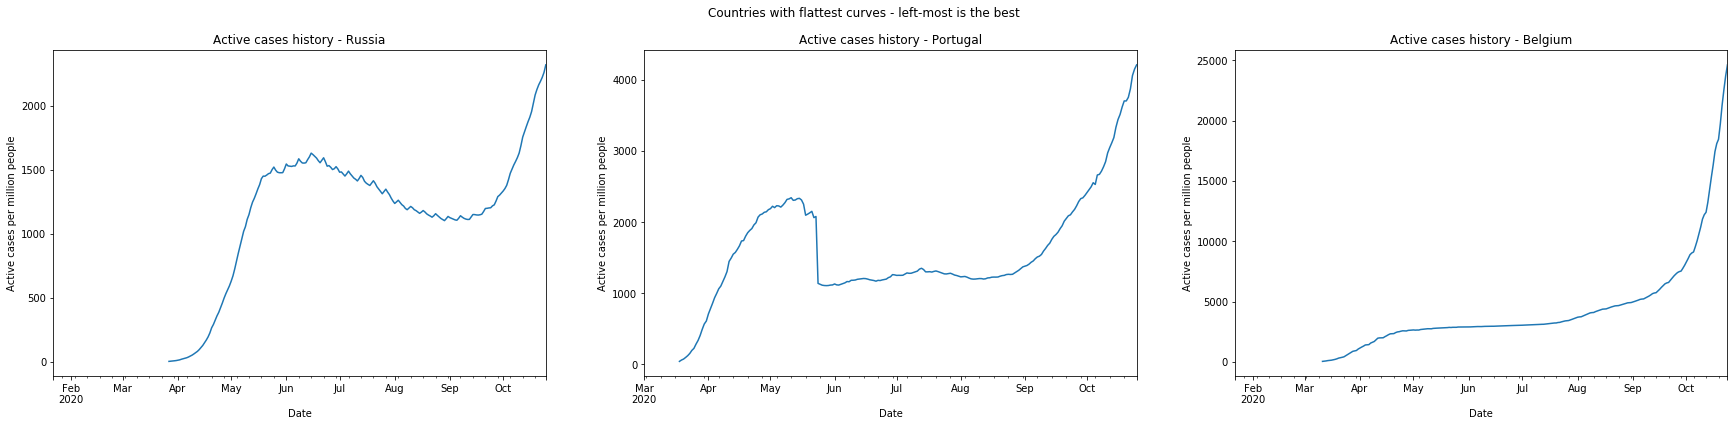

In [16]:
def plot_active_cases_per_million(country, axis):
    eu_df[eu_df.iso_code == country].plot(x='date', y='active_cases_per_million', ax=axis, legend=False)
    country_name = eu_df[eu_df.iso_code == country].iloc[0].location
    axis.set_xlabel('Date')
    axis.set_ylabel('Active cases per million people')
    axis.set_title(f'Active cases history - {country_name}')
    

_, axes = plt.subplots(1, 3, figsize=(30, 6))
best_countries = active_cases_perc_delta_average_by_country.head(3).index.values
[plot_active_cases_per_million(country, axis) for (country, axis) in zip(best_countries, axes)]
plt.suptitle('Countries with flattest curves - left-most is the best')

Similarly, we can inspect active cases histories of countries that allegedly did worst (left-most plot belongs to the country with worst evaluation).

Text(0.5, 0.98, 'Countries with least flattest curves - left-most is the worst')

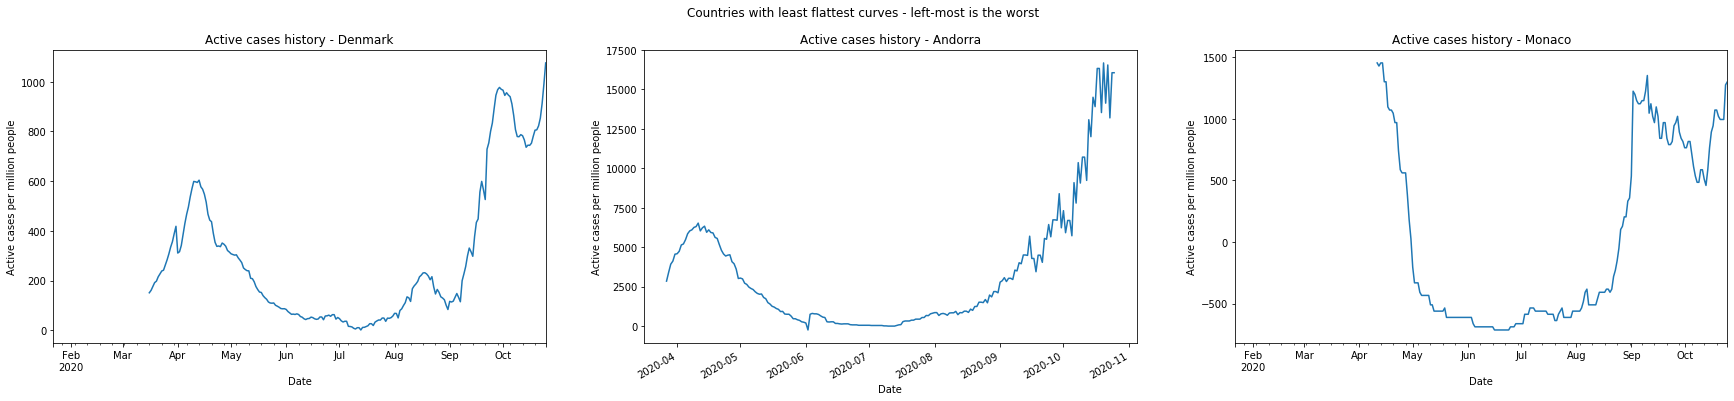

In [17]:
_, axes = plt.subplots(1, 3, figsize=(30, 6))
worst_countries = reversed(active_cases_perc_delta_average_by_country.tail(3).index.values)
[plot_active_cases_per_million(country, axis) for (country, axis) in zip(worst_countries, axes)]
plt.suptitle('Countries with least flattest curves - left-most is the worst')

<a id='Q2'></a>
## 2. Is COVID-19 case fatality rate lower in European countries that have a flatter active cases curve?

To answer this question we first need to calculate case fatality rates for countries we analyzed in [Question #1](#Q1). We calculate the case fatality rate by dividing total deaths by total cases.

In [18]:
case_fatality_rate = eu_last_day_stats.total_deaths / eu_last_day_stats.total_cases * 100
case_fatality_rate.head()

iso_code
ALB    2.508219
AND    1.708767
AUT    1.226025
BEL    3.365157
BGR    2.885895
dtype: float64

We then create a data frame with case fatality rate and our curve flatness evaluation from [Question #1](#Q1).

In [19]:
corr_frame = pd.DataFrame([active_cases_perc_delta_average_by_country, case_fatality_rate], ['average_perc_active_cases_delta', 'case_fatality_rate']).T.dropna()
corr_frame.head()

,average_perc_active_cases_delta,case_fatality_rate
RUS,0.792024,1.724657
PRT,1.144498,2.012988
BEL,1.297583,3.365157
MDA,1.307895,2.347761
FRA,1.542247,3.188688


Finally, we plot the data frame using a scatter plot and add a trendline using linear interpolation.

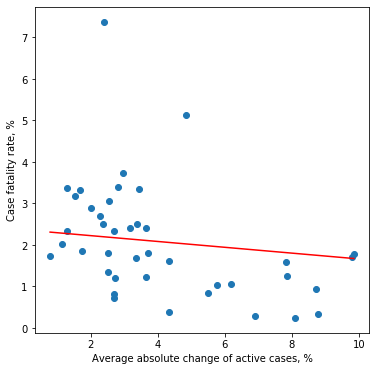

In [20]:
plt.figure(figsize=(6, 6))
x = corr_frame.average_perc_active_cases_delta.values
y = corr_frame.case_fatality_rate.values
plt.scatter(x, y)

plt.xlabel('Average absolute change of active cases, %')
plt.ylabel('Case fatality rate, %')

linearInterpolation = make_pipeline(PolynomialFeatures(1), Lasso())
linearInterpolation.fit(x.reshape(-1, 1), y.reshape(-1, 1))
plt.plot(x, linearInterpolation.predict(x.reshape(-1, 1)), '-r')

We can notice a slight negative correlation between case fatality rate and active cases curve flatness. We can verify this by calculating Pearson correlation coefficient.

In [21]:
np.ma.corrcoef(x, y)[0, 1]

-0.4244472679423325

The negative correlation indicates that __countries with flatter active cases curve have a slightly higher case fatality rate__. At first it might seem counter intuitive as "flatten the curve" strategy aims to limit deaths. However, this result can be explained:
* __Countries that managed to flatten the curve did so after active cases exceeded the healthcare system capacity__. That could mean that some patients might have received inadequate care and died as a result.
* __Countries with volatile curve had small outburst that got quickly contained__. Resulting spikes in active cases did not reach healthcare system capacity therefore all patients received adequate care.

<a id='Q3'></a>
## 3. Does using active cases data improve prediction of daily deaths in Belgium accuracy compared to using only historical daily deaths data when using Linear Regression? 

### Preparing inputs and outputs

We will use the data from the past 14 days as inputs for our models.

In [22]:
historical_days = 14

Let us create a data frame with Belgium's statistics using data starting with the day the total death count per million people reached 100.

In [23]:
belgium_stats = eu_df[eu_df.iso_code == 'BEL'].set_index('date')

threshold_index = belgium_stats[belgium_stats.total_deaths_per_million > 100].index[0]
relevant_stats = belgium_stats.loc[threshold_index:]

We then create a data frame where each day has our inputs array (daily deaths for the past 14 days) and expected output (daily deaths for that day).

In [24]:
def append_window(dict, window):
    key = window.index[-1]
    dict[key] = (window.head(-1).values, window.tail(1).values[0])


new_deaths_set = {}
relevant_stats.new_deaths[1:].rolling(historical_days + 1).apply(lambda window : append_window(new_deaths_set, window) or 0)

deaths_df = pd.DataFrame(new_deaths_set, index=['new_deaths_history', 'new_deaths']).T
deaths_df

,new_deaths_history,new_deaths
2020-04-15,"[208.0, 232.0, 219.0, 236.0, 270.0, 246.0, 257...",261
2020-04-16,"[232.0, 219.0, 236.0, 270.0, 246.0, 257.0, 277...",280
2020-04-17,"[219.0, 236.0, 270.0, 246.0, 257.0, 277.0, 321...",246
2020-04-18,"[236.0, 270.0, 246.0, 257.0, 277.0, 321.0, 271...",205
2020-04-19,"[270.0, 246.0, 257.0, 277.0, 321.0, 271.0, 302...",208
...,...,...
2020-10-20,"[14.0, 18.0, 20.0, 20.0, 19.0, 22.0, 25.0, 36....",49
2020-10-21,"[18.0, 20.0, 20.0, 19.0, 22.0, 25.0, 36.0, 34....",47
2020-10-22,"[20.0, 20.0, 19.0, 22.0, 25.0, 36.0, 34.0, 41....",55
2020-10-23,"[20.0, 19.0, 22.0, 25.0, 36.0, 34.0, 41.0, 35....",53


We do the same with active cases data, taking the active cases % change for the past 14 days as inputs.

In [25]:
active_cases_set = {}

relevant_stats['active_cases_perc_change'] = relevant_stats.active_cases.diff() / relevant_stats.active_cases.shift(1) * 100
relevant_stats.active_cases_perc_change.rolling(historical_days + 1).apply(lambda window : append_window(active_cases_set, window) or 0)

active_cases_df = pd.DataFrame(active_cases_set, index=['active_cases_delta_history', 'active_cases_delta']).T
active_cases_df

,active_cases_delta_history,active_cases_delta
2020-04-15,"[8.341377091377092, 6.837924122058059, 6.12925...",4.55679
2020-04-16,"[6.837924122058059, 6.129256428075052, 7.09140...",3.69213
2020-04-17,"[6.129256428075052, 7.091409114719749, 0.90492...",4.0801
2020-04-18,"[7.091409114719749, 0.9049220421889331, 1.1149...",3.05535
2020-04-19,"[0.9049220421889331, 1.11494879718839, 9.02498...",0.388156
...,...,...
2020-10-20,"[4.861939098014724, 5.0407883338146116, 5.7481...",6.88191
2020-10-21,"[5.0407883338146116, 5.748183020910293, 5.2594...",7.84248
2020-10-22,"[5.748183020910293, 5.25943798591309, 5.891932...",5.99084
2020-10-23,"[5.25943798591309, 5.891932359319889, 3.071406...",5.13292


Finally, we combine the two data frames but dropping the `active_cases_delta` column as it won't be needed.

In [26]:
predictions_df = pd.concat([active_cases_df['active_cases_delta_history'], deaths_df], join='inner', axis='columns')
predictions_df

,active_cases_delta_history,new_deaths_history,new_deaths
2020-04-15,"[8.341377091377092, 6.837924122058059, 6.12925...","[208.0, 232.0, 219.0, 236.0, 270.0, 246.0, 257...",261
2020-04-16,"[6.837924122058059, 6.129256428075052, 7.09140...","[232.0, 219.0, 236.0, 270.0, 246.0, 257.0, 277...",280
2020-04-17,"[6.129256428075052, 7.091409114719749, 0.90492...","[219.0, 236.0, 270.0, 246.0, 257.0, 277.0, 321...",246
2020-04-18,"[7.091409114719749, 0.9049220421889331, 1.1149...","[236.0, 270.0, 246.0, 257.0, 277.0, 321.0, 271...",205
2020-04-19,"[0.9049220421889331, 1.11494879718839, 9.02498...","[270.0, 246.0, 257.0, 277.0, 321.0, 271.0, 302...",208
...,...,...,...
2020-10-20,"[4.861939098014724, 5.0407883338146116, 5.7481...","[14.0, 18.0, 20.0, 20.0, 19.0, 22.0, 25.0, 36....",49
2020-10-21,"[5.0407883338146116, 5.748183020910293, 5.2594...","[18.0, 20.0, 20.0, 19.0, 22.0, 25.0, 36.0, 34....",47
2020-10-22,"[5.748183020910293, 5.25943798591309, 5.891932...","[20.0, 20.0, 19.0, 22.0, 25.0, 36.0, 34.0, 41....",55
2020-10-23,"[5.25943798591309, 5.891932359319889, 3.071406...","[20.0, 19.0, 22.0, 25.0, 36.0, 34.0, 41.0, 35....",53


We then split our data into training and testing sets. Testing set will consist of the last 30 days data and training set will use all other available data.

In [27]:
training_set = predictions_df[:-30]
testing_set = predictions_df[-30:]

### Training the models

We will train two models - one will use only the historical daily deaths data while the second one will additionally receive active cases % change data.

We will use [Lasso model](https://scikit-learn.org/stable/modules/linear_model.html#lasso) from `scikit-learn` module. Lasso is a linear model that tends to use fewer non-zero coefficients, effectively not using some of the inputs it receives. That will allow to evaluate if the model deems active cases data an unnecessary feature.

#### Historical-deaths-only model

Let us first train the model using only the historical daily deaths data and see how it performs using test data.

In [28]:
def fit_regression_model(inputs, outputs):
    model = make_pipeline(StandardScaler(), Lasso())
    model.fit(inputs, outputs)
    return model


training_inputs = np.stack(training_set['new_deaths_history'])
deaths_only_model = fit_regression_model(training_inputs, training_set['new_deaths'])

testing_inputs = np.stack(testing_set['new_deaths_history'])
deaths_only_model.score(testing_inputs, testing_set['new_deaths'])

0.6509868022494054

Text(0.5, 1.0, 'Daily deaths in Belgium for past month --\n predictions using daily deaths historic data')

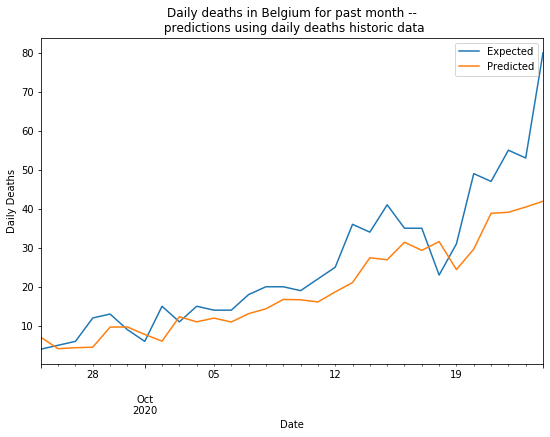

In [29]:
def predict_and_plot_new_deaths(model, x_values, inputs, expected):
    df = pd.DataFrame(data=[expected, model.predict(inputs)], columns=x_values, index=['Expected', 'Predicted']).T
    df.plot(figsize=(9, 6), xlabel='Date', ylabel='Daily Deaths')

predict_and_plot_new_deaths(deaths_only_model, testing_set.index, testing_inputs, testing_set['new_deaths'].values)
plt.title('Daily deaths in Belgium for past month --\n predictions using daily deaths historic data')

The model score is not the greatest (`~0.65`) and looking at the graph it seems that the model tends to return similar outputs to the most recent inputs.

We can take a look at coefficients that it ended up using.

In [30]:
deaths_only_model.get_params()['lasso'].coef_

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , 17.40011606,
        0.        ,  0.        ,  4.77663085, 33.26886769])

The model uses only the 2 most recent days and 5th most recent days ignoring the rest of the historic data.

#### Active-cases-change model

Let's see if using active cases % change will improve the model's predictions. We use the same approach as before but use more features.

In [31]:
training_inputs = np.concatenate((np.stack(training_set['new_deaths_history']), np.stack(training_set['active_cases_delta_history'])), axis=1)
active_cases_model = fit_regression_model(training_inputs, training_set['new_deaths'])

testing_inputs = np.concatenate((np.stack(testing_set['new_deaths_history']), np.stack(testing_set['active_cases_delta_history'])), axis=1)
active_cases_model.score(testing_inputs, testing_set['new_deaths'])

0.8052730367039503

Text(0.5, 1.0, 'Daily deaths in Belgium for past month --\n predictions using daily deaths and active cases delta historic data')

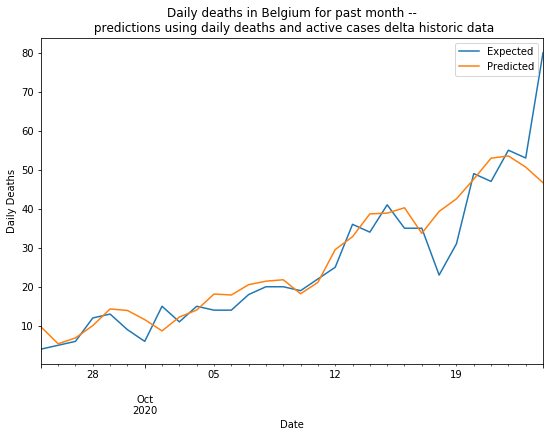

In [32]:
predict_and_plot_new_deaths(active_cases_model, testing_set.index, testing_inputs, testing_set['new_deaths'].values)
plt.title('Daily deaths in Belgium for past month --\n predictions using daily deaths and active cases delta historic data')

The model score is better compared to daily-deaths-only model (`~0.81`). Looking at the graph predictions seem more interesting as well. They seem to be less reliant on the past few days' inputs.

Let us check the coefficients for daily cases inputs.

In [33]:
coeffs = active_cases_model.get_params()['lasso'].coef_
coeffs[-historical_days:]

array([ 0.        ,  0.        ,  0.02444053,  0.        ,  0.        ,
        0.        , -0.        ,  0.        ,  1.76430173,  1.2642759 ,
        0.04148979, -0.        , -0.        ,  0.        ])

The 4 non-zero coefficients indicate that the daily cases inputs do get used by the model. It's also interesting that the oldest inputs get used - it would make sense that rapid change in active cases will have a delayed effect on new deaths.

Let us see the coefficients for daily deaths inputs.

In [34]:
coeffs[:historical_days]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , 18.80466249,
        0.        ,  0.        ,  8.46663627, 26.51934282])

Similarly to daily-deaths-only model, only the 2 most recent and the 5th most recent inputs are used.


### Conclusion

Using active cases data seemed to improve the module performance. That can be verified by both the coefficient of determinations of the models (`~0.81` vs. `~0.65`) and the plots from testing. The plot for daily-deaths-only model seems to be mimicking inputs where predictions using active cases data seem more genuine.